In [1]:
%matplotlib inline
from matplotlib import pyplot
import numpy
from tappingsim.furnaces import SubmergedArcFurnace, bedmodel_ergun, fdmodel_cheng
from tappingsim.launders import SimpleSisoLaunder
from tappingsim.ladles import CylindricalLadle, overflowmodel_step
from tappingsim.tappingsystems import SAFWithLadles

#### Initialise furnace, launder, and ladle objects

In [2]:
fparams = {'powerMVA': 40, 'powerfactor': 0.8, 'metalSER': 3.5, 'slagmetalmassratio': 1.2,
           'furnacediameter': 12, 'activeareafraction': 0.75, 'tapholediameter': 0.075, 'tapholelength': 1.5,
           'tapholeroughness': 1e-3, 'tapholeheight': 0.1, 'densitymetal': 7000, 'densityslag': 3000,
           'viscositymetal': 0.005, 'viscosityslag': 0.1, 'particlediameter': 0.02, 'particlesphericity': 0.8,
           'bedporosity': 0.5, 'bedmindiameter': 0.15, 'bedmaxdiameter': 20, 'bedmodel': bedmodel_ergun,
           'entrykl': 0.25, 'fdmodel': fdmodel_cheng, 'hmetal_init': 0.25, 'hslag_init': 0.4}

saf = SubmergedArcFurnace(**fparams)

In [3]:
ldr = SimpleSisoLaunder()

In [4]:
lparams = {'diameter': 1.8, 'depth': 2, 'overflowmodel': overflowmodel_step, 'overflowconsts': [],
           'hmetal_init': 0, 'hslag_init': 0}

ldls = [CylindricalLadle(**lparams) for n in range(3)]

#### Initialise a tapping system object

In [5]:
tapsys = SAFWithLadles(furnace=saf, launder=ldr, ladles=ldls)

#### Simulate a sequence of taps

In [6]:
# Re-initialise internal state variables to starting values
tapsys.furnace.hmetal = fparams['hmetal_init']
tapsys.furnace.hslag = fparams['hslag_init']
tapsys.empty_ladles()

# Discretise time periods for tapping duration and tapping interval
timeopen = numpy.linspace(0, 2400, 300)
timeclosed = numpy.linspace(0, 10800, 100)

# Lists to store data for graphical display
datapoints = [(0, tapsys.furnace.hmetal, tapsys.furnace.hslag, 
               tapsys.ladles[0].hmetal, tapsys.ladles[0].hslag)]
tapmasses = []

# Run simulation
for ntaps in range(10):
    tapsys.reset_all_totalisers()
    tapsys.open_taphole()
    for deltat in timeopen[1:] - timeopen[:-1]:
        tapsys.calc_dt(dt=deltat)
        datapoints.append((datapoints[-1][0]+deltat, tapsys.furnace.hmetal, tapsys.furnace.hslag, 
                           tapsys.ladles[0].hmetal, tapsys.ladles[0].hslag))
    tapsys.close_taphole()
    tapmasses.append((tapsys.metalmasstotaliser, tapsys.slagmasstotaliser))
    tapsys.empty_ladles()
    for deltat in timeclosed[1:] - timeclosed[:-1]:
        tapsys.calc_dt(dt=deltat)
        datapoints.append((datapoints[-1][0]+deltat, tapsys.furnace.hmetal, tapsys.furnace.hslag, 
                           tapsys.ladles[0].hmetal, tapsys.ladles[0].hslag))

# Reorganise data for easier plotting
datapoints = numpy.array(datapoints).transpose()
tapmasses = numpy.array(tapmasses).transpose()

#### Plot data from simulation

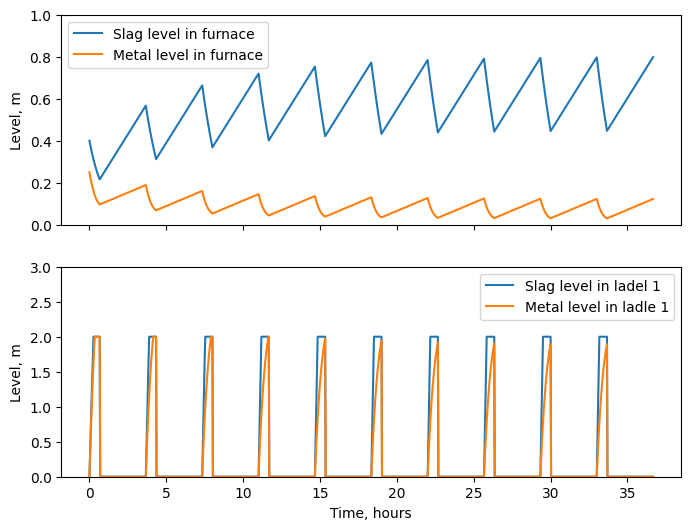

In [7]:
fig, axs = pyplot.subplots(2, 1, figsize=(8,6), sharex=True)

ax = axs[0]
ax.set_ylabel('Level, m')
ax.set_ylim(0, 1)
ax.plot(datapoints[0]/3600, datapoints[2], label='Slag level in furnace')
ax.plot(datapoints[0]/3600, datapoints[1], label='Metal level in furnace')
ax.legend()

ax = axs[1]
ax.set_xlabel('Time, hours')
ax.set_ylabel('Level, m')
ax.set_ylim(0, 3)
ax.plot(datapoints[0]/3600, datapoints[4], label='Slag level in ladel 1')
ax.plot(datapoints[0]/3600, datapoints[3], label='Metal level in ladle 1')
ax.legend()

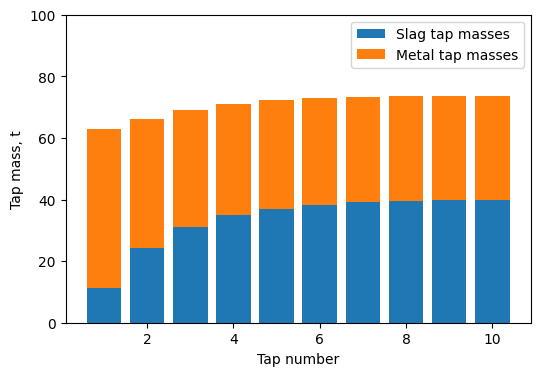

In [8]:
fig, ax = pyplot.subplots(figsize=(6,4))

tapnumbers = numpy.arange(0, len(tapmasses[0]), 1) + 1
ax.set_xlabel('Tap number')
ax.set_ylabel('Tap mass, t')
ax.set_ylim(0, 100)
ax.bar(tapnumbers, tapmasses[1]/1000, label='Slag tap masses')
ax.bar(tapnumbers, tapmasses[0]/1000, bottom=tapmasses[1]/1000, label='Metal tap masses')
ax.legend()